<a href="https://colab.research.google.com/github/SuperMusey/FoundationOfPrivacy/blob/main/MIA_phase2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MIA FOR Finetuned LLM

In [1]:
# update the downloading command as my LFS runs out so cannot directly clone model.safetensors
%cd /content

!git clone https://github.com/2020pyfcrawl/18734-17731_Project_Phase2_3.git

%cd /content/18734-17731_Project_Phase2_3


/content
Cloning into '18734-17731_Project_Phase2_3'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 55 (delta 8), reused 15 (delta 5), pack-reused 36 (from 1)
Receiving objects: 100% (55/55), 55.70 MiB | 15.11 MiB/s, done.
Resolving deltas: 100% (11/11), done.
/content/18734-17731_Project_Phase2_3


### Variables and libraries

In [ ]:
# install the required libraries if you have not done so (on you local machine or GPU server)
# you may not need to run this if you use colab as they are pre-installed, but you can always do it.
%pip install -r requirements.txt

In [6]:
import os, math, argparse
os.environ.setdefault("TRANSFORMERS_NO_TORCHVISION", "1")

import torch
import numpy as np
from datasets import load_from_disk
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.metrics import roc_auc_score, roc_curve, auc as _auc
import matplotlib.pyplot as plt
import json
from pathlib import Path
from datasets import Dataset

In [7]:
# global variable, check the current position to adjust the path
phase = "train" # or train / val / final
target_model_dir = f"./models/{phase}/gpt2_3_lora32_adamw_b8_lr2"
data_dir = f"./data/{phase}/"
batch_size = 50

# you may change block size if you like (max length for the tokenizer below)
block_size = 512

### Data pre-processing

In [8]:
def tokenize_dataset(ds, tok, max_len):
    ds = ds.filter(lambda ex: ex.get("text", None) and len(ex["text"].strip()) > 0)

    def _map(ex):
        out = tok(ex["text"], truncation=True, padding=True, max_length=max_len, return_attention_mask=True)
        out["labels"] = out["input_ids"].copy()
        return out

    ds = ds.map(_map, batched=True, remove_columns=ds.column_names)
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return ds

def _read_json(path: Path):
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

In [9]:
# for tests, you may only load a part of the data to save time while implementing,
# as running all 2000 samples on CPU may be slow, but not a problem here for GPU

# load test data
data_dir = Path(data_dir)
test_path = data_dir / "test.json"
test_items = _read_json(test_path)
ds_test = Dataset.from_dict({"text": test_items})

# tokenizer the test data
tokenizer = AutoTokenizer.from_pretrained(target_model_dir, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side="right"

ds_test = tokenize_dataset(ds_test, tokenizer, block_size)
dl_test = DataLoader(ds_test, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# you may load the model using the code:

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [10]:
model = AutoModelForCausalLM.from_pretrained(target_model_dir, dtype="auto").to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

### MIA

Implement your attack here! \
Hint: use shadow models.

In [12]:
# implement your attack here
@torch.no_grad()
def your_attack():
    """
    Supervised canary-based MIA using shadow model features
    Returns continuous probability scores for better TPR@1%FPR performance
    """
    print("="*80)
    print("SUPERVISED CANARY-BASED MIA")
    print("="*80)

    # Configuration
    SHADOW_MODEL_DIR = "./models/shadow_model_canary"  # Adjust path as needed
    CANARY_DATA_DIR = "./data/shadow_data_canary"
    MAX_LEN = 512

    # Load target test data (already loaded in notebook)
    target_test =  test_items

    print(f"Target test samples: {len(target_test)}")

    # ========== STEP 1: Collect Shadow Model Features ==========
    print("\nSTEP 1: Collecting Shadow Model Training Data...")

    shadow_features = []  # Loss values
    shadow_labels = []    # 1=member, 0=non-member

    for shadow_id in range(5):
        shadow_path = Path(SHADOW_MODEL_DIR) / f"shadow_{shadow_id}" / "gpt2_shadow"
        canary_mapping_path = Path(CANARY_DATA_DIR) / f"shadow_{shadow_id}" / "canary_mapping.json"

        if not shadow_path.exists():
            print(f"⚠ Shadow {shadow_id} not found at {shadow_path}")
            continue

        if not canary_mapping_path.exists():
            print(f"⚠ Canary mapping {shadow_id} not found")
            continue

        print(f"Processing shadow model {shadow_id}...")

        # Load shadow model
        shadow_model = AutoModelForCausalLM.from_pretrained(str(shadow_path)).to(device)
        shadow_tokenizer = AutoTokenizer.from_pretrained(str(shadow_path))
        if shadow_tokenizer.pad_token is None:
            shadow_tokenizer.pad_token = shadow_tokenizer.eos_token

        # Load canary mapping to know which samples are members
        canary_mapping = json.load(open(canary_mapping_path))
        my_canary_indices = set(canary_mapping["canary_indices"])

        # Compute losses on target test set
        shadow_model.eval()
        test_losses = []

        for i in range(0, len(target_test), batch_size):
            batch_texts = target_test[i:i+batch_size]

            # Tokenize
            encodings = shadow_tokenizer(
                batch_texts,
                max_length=MAX_LEN,
                truncation=True,
                padding=True,
                return_tensors="pt"
            )

            input_ids = encodings["input_ids"].to(device)
            attention_mask = encodings["attention_mask"].to(device)

            # Compute loss
            outputs = shadow_model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)

            # Per-sample loss calculation
            shift_logits = outputs.logits[:, :-1, :].contiguous()
            shift_labels = input_ids[:, 1:].contiguous()
            shift_mask = attention_mask[:, 1:].contiguous()

            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            loss = loss.view(shift_labels.size())

            # Mask and average
            per_sample_loss = (loss * shift_mask).sum(dim=1) / shift_mask.sum(dim=1)
            test_losses.extend(per_sample_loss.cpu().numpy())

        # Create labels: 1 if this shadow saw the sample (member), 0 otherwise
        test_labels = [1 if idx in my_canary_indices else 0 for idx in range(len(target_test))]

        # Add to training data
        shadow_features.extend(test_losses)
        shadow_labels.extend(test_labels)

        print(f"  Added {len(test_losses)} samples ({sum(test_labels)} members)")

        del shadow_model
        torch.cuda.empty_cache()

    # Convert to numpy arrays
    shadow_features = np.array(shadow_features)
    shadow_labels = np.array(shadow_labels)

    print(f"\nTotal training data: {len(shadow_features)} samples")
    print(f"  Members: {sum(shadow_labels)}")
    print(f"  Non-members: {len(shadow_labels) - sum(shadow_labels)}")

    # ========== STEP 2: Train Attack Classifier ==========
    print("\nSTEP 2: Training Attack Classifier...")

    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import roc_auc_score

    # Use negative loss as feature (lower loss = more likely member)
    X = (-shadow_features).reshape(-1, 1)
    y = shadow_labels

    # Split for validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Train classifier
    attack_model = LogisticRegression(random_state=42, max_iter=1000)
    attack_model.fit(X_train, y_train)

    # Validate
    val_probs = attack_model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_probs)
    print(f"Validation AUC: {val_auc:.4f}")

    if val_auc < 0.6:
        print("⚠ Warning: Low validation AUC - shadow models may have weak signal")

    # ========== STEP 3: Attack Target Model ==========
    print("\nSTEP 3: Attacking Target Model...")

    # Compute target model losses
    target_losses = []
    model.eval()

    for i in range(0, len(target_test), batch_size):
        batch_texts = target_test[i:i+batch_size]

        # Tokenize
        encodings = tokenizer(
            batch_texts,
            max_length=MAX_LEN,
            truncation=True,
            padding=True,
            return_tensors="pt"
        )

        input_ids = encodings["input_ids"].to(device)
        attention_mask = encodings["attention_mask"].to(device)

        # Compute loss
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)

        # Per-sample loss
        shift_logits = outputs.logits[:, :-1, :].contiguous()
        shift_labels = input_ids[:, 1:].contiguous()
        shift_mask = attention_mask[:, 1:].contiguous()

        loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        loss = loss.view(shift_labels.size())

        # Mask and average
        per_sample_loss = (loss * shift_mask).sum(dim=1) / shift_mask.sum(dim=1)
        target_losses.extend(per_sample_loss.cpu().numpy())

    target_losses = np.array(target_losses)

    # Make predictions using trained classifier
    X_target = (-target_losses).reshape(-1, 1)
    target_scores = attack_model.predict_proba(X_target)[:, 1]

    print(f"Target predictions:")
    print(f"  Mean score: {target_scores.mean():.4f}")
    print(f"  Std score: {target_scores.std():.4f}")
    print(f"  Min score: {target_scores.min():.4f}")
    print(f"  Max score: {target_scores.max():.4f}")

    return target_scores

# Run the attack
scores_test = your_attack()

SUPERVISED CANARY-BASED MIA
Target test samples: 2000

STEP 1: Collecting Shadow Model Training Data...
Processing shadow model 0...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.79 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.55 GiB is free. Process 5854 has 13.19 GiB memory in use. Of the allocated memory 12.32 GiB is allocated by PyTorch, and 763.83 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Result

In [ ]:
# load the label here to compute the performance, you will only have full access to the label in train set to test your method
if phase == "train":
    label_path = data_dir / "test_label.json"
    label_items = _read_json(label_path)

    y_true = np.array(label_items)
    scores = np.array(scores_test)
    fpr, tpr, thr = roc_curve(y_true, scores)
    auc_val = roc_auc_score(y_true, scores)
    print(auc_val)

    print(max(tpr[fpr < 0.01])) # TPR @ 0.01FPR
    # WE ONLY CARE TPR @ 0.01FPR!!! SO INCREASE THIS AS MUCH AS POSSIBLE!!!
elif phase == "val" or phase == "final":
    pred_path = data_dir / "prediction.csv"
    with open(pred_path, "w", encoding="utf-8") as f:
        for s in scores_test:
            f.write(json.dumps(float(s), ensure_ascii=False) + "\n")
else:
    print("Wrong phase.")

### Packaging the submission

zip the prediction file and upload to the leaderboard.

In [ ]:
import os
from pathlib import Path
import zipfile

with zipfile.ZipFile(f"project_submission.zip", 'w') as zipf:
    for phase in ["val", "final"]:
        data_dir = f"./data/{phase}/"
        data_dir = Path(data_dir)

        file = data_dir / "prediction.csv"
        if file.exists():
            arcname = os.path.join(phase, file.name)
            zipf.write(file, arcname=arcname)
        else:
            raise FileNotFoundError(f"`prediction.csv` not found in {data_dir}.")

### Visualization

A few visualizations that may help you develop your method and write reports.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

eps = 1e-12
fpr_ = np.clip(fpr, 1e-5, 1)
tpr_ = np.clip(tpr, 1e-5, 1)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(fpr_, tpr_, lw=2, label=f'ROC (AUC = {auc_val:.4f})')
ax.plot([1e-5, 1], [1e-5, 1], lw=2, ls='--', label='Chance')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-5, 1.0)
ax.set_ylim(1e-5, 1.0)

ticks = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.get_xaxis().set_minor_formatter(plt.NullFormatter())
ax.get_yaxis().set_minor_formatter(plt.NullFormatter())

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('MIA ROC (log–log focus on small FPR/TPR)')
ax.legend(loc='lower right')
ax.grid(True, which='both', alpha=0.5)

plt.show()

NameError: name 'fpr' is not defined

In [ ]:
# draw distribution
import matplotlib.pyplot as plt
import seaborn as sns

# y_true = np.array(label_items)
# scores = np.array(scores_test)

scores_mem = scores[y_true == 1]
scores_non = scores[y_true == 0]

plt.figure(figsize=(12, 6))
sns.histplot(scores_mem, bins=50, color='salmon', kde=True, label='member')
sns.histplot(scores_non, bins=50, color='skyblue', kde=True, label='non-member')

threshold_value = np.percentile(scores_non, q=99)
print(threshold_value)
plt.axvline(
    x=threshold_value,
    color='purple',
    linestyle='--',
    linewidth=2,
    label=f'0.01 FPR: {threshold_value:.2f}'
)


plt.title('Loss distribution', fontsize=16)
plt.xlabel('Loss', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(fontsize=10)

plt.show()

In [ ]:
# draw ROC curve and attach the figure in the report
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'MIA ROC Curve for Train Data')
plt.legend(loc="lower right")
plt.grid(alpha=0.5)
plt.show()

**ADDITIONALS**

**For Shadow Data**

In [ ]:
#!/usr/bin/env python
# prepare_data.py
# curate training data for the model

import os, json, random
from pathlib import Path
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer

# dataset - seed
# 0 - 4042
# 1 - 3042
# 2 - 2042
# 3 - 1042
# 4 - 420

OUTDIR = "shadow_data/shadow_0"
SEED = 4042
TRAIN_PER_SRC = 10_000
MIN_TOKENS = 25
TEST_MEMBERS = 1000
TEST_NONMEMBERS = 1000

def set_seed_all(seed: int):
    import numpy as np
    random.seed(seed); np.random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    except Exception:
        pass

def ensure_text_column(ds: Dataset, src: str) -> Dataset:
    if src == "wikitext103":
        assert "text" in ds.column_names
        return ds.remove_columns([c for c in ds.column_names if c != "text"])
    raise ValueError(src)

def basic_clean(ds: Dataset) -> Dataset:
    ds = ds.filter(lambda ex: isinstance(ex.get("text", None), str) and len(ex["text"].strip()) > 0)
    def _strip_map(ex): return {"text": " ".join(ex["text"].split())}
    return ds.map(_strip_map, batched=False)

def filter_by_tokens(ds: Dataset, tok, min_tokens: int) -> Dataset:
    def _len_map(batch):
        enc = tok(batch["text"], add_special_tokens=False)
        return {"_tok_len": [len(ids) for ids in enc["input_ids"]]}
    ds = ds.map(_len_map, batched=True)
    ds = ds.filter(lambda ex: ex["_tok_len"] >= min_tokens)
    return ds.remove_columns(["_tok_len"])

def sample_n(ds: Dataset, n: int, seed: int):
    n = min(n, len(ds))
    idx = list(range(len(ds)))
    random.Random(seed).shuffle(idx)
    take = sorted(idx[:n])
    return ds.select(take), set(take)

def dump_json(path: Path, obj):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def main():
    set_seed_all(SEED)
    os.makedirs(OUTDIR, exist_ok=True)

    tok = AutoTokenizer.from_pretrained("gpt2", use_fast=True)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token

    # ---------- Load & filter (WikiText-103-raw-v1) ----------
    wiki_raw = load_dataset("Salesforce/wikitext", "wikitext-103-raw-v1")["train"]
    wiki = ensure_text_column(wiki_raw, "wikitext103")
    wiki = basic_clean(wiki)
    wiki = filter_by_tokens(wiki, tok, MIN_TOKENS)

    # train set
    wiki_train, wiki_train_idx = sample_n(wiki, TRAIN_PER_SRC, SEED + 1)

    out_dir = Path(OUTDIR)
    train_json = [{"text": ex["text"]} for ex in wiki_train]
    dump_json(out_dir / "train_finetune.json", train_json)

    train_texts = [ex["text"] for ex in wiki_train]
    train_set = set(train_texts)

    # Get member samples (from training set)
    member_samples = random.sample(train_texts, min(TEST_MEMBERS, len(train_texts)))

    # Get non-member samples (from wiki but NOT in training)
    nonmember_candidates = [ex["text"] for ex in wiki if ex["text"] not in train_set]
    nonmember_samples = random.sample(nonmember_candidates, min(TEST_NONMEMBERS, len(nonmember_candidates)))

    # Combine: members first, then non-members
    test_texts = member_samples + nonmember_samples
    test_labels = [1] * len(member_samples) + [0] * len(nonmember_samples)

    # Save test.json and test_label.json
    dump_json(out_dir / "test.json", test_texts)
    dump_json(out_dir / "test_label.json", test_labels)

    print(f"[OK] Train JSON ({len(train_texts)} samples) saved to {OUTDIR}")
    print(f"[OK] Test JSON ({len(member_samples)} members + {len(nonmember_samples)} non-members) saved to {OUTDIR}")


    print("[OK] JSON saved to", OUTDIR)

if __name__ == "__main__":
    main()


[OK] Train JSON (10000 samples) saved to shadow_data/shadow_0
[OK] Test JSON (1000 members + 1000 non-members) saved to shadow_data/shadow_0
[OK] JSON saved to shadow_data/shadow_0


**Canary Data Set Gen**

In [ ]:
#!/usr/bin/env python
# prepare_canary_shadow_data.py
# Prepare shadow model data using canary-based partitioning

import os, json, random
from pathlib import Path
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer

def set_seed_all(seed: int):
    import numpy as np
    random.seed(seed)
    np.random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    except Exception:
        pass

def basic_clean_text(text):
    """Clean a single text string"""
    if not isinstance(text, str) or len(text.strip()) == 0:
        return None
    return " ".join(text.split())

def main():
    set_seed_all(42)  # Global seed for reproducibility

    # ========== STEP 1: Load Target Test Set (Canaries) ==========
    print("="*60)
    print("STEP 1: Loading Target Test Set")
    print("="*60)

    target_test_path = Path("./data/train/test.json")
    if not target_test_path.exists():
        raise FileNotFoundError(f"Target test file not found: {target_test_path}")

    target_test_items = json.load(open(target_test_path))
    print(f"Loaded {len(target_test_items)} test samples from target model\n")

    # ========== STEP 2: Split into 5 Canary Sets ==========
    print("="*60)
    print("STEP 2: Creating Canary Partitions")
    print("="*60)

    # Shuffle with fixed seed
    random.seed(42)
    shuffled_indices = list(range(len(target_test_items)))
    random.shuffle(shuffled_indices)

    canary_sets = []
    canary_size = len(target_test_items) // 5

    for i in range(5):
        start_idx = i * canary_size
        end_idx = (i + 1) * canary_size if i < 4 else len(target_test_items)
        canary_indices = shuffled_indices[start_idx:end_idx]
        canary_texts = [target_test_items[idx] for idx in canary_indices]
        canary_sets.append(canary_texts)
        print(f"Canary set {i}: {len(canary_texts)} samples")

    # Convert to sets for fast lookup
    canary_sets_lookup = [set(texts) for texts in canary_sets]
    all_canaries_set = set(target_test_items)

    # ========== STEP 3: Load WikiText for Filling ==========
    print(f"\n{'='*60}")
    print("STEP 3: Loading WikiText-103")
    print("="*60)

    tok = AutoTokenizer.from_pretrained("gpt2", use_fast=True)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token

    wiki_raw = load_dataset("Salesforce/wikitext", "wikitext-103-raw-v1")["train"]
    print(f"✓ Loaded {len(wiki_raw)} WikiText samples")

    # Clean and filter WikiText, excluding ALL canaries
    wiki_texts = []
    for item in wiki_raw:
        if "text" in item:
            cleaned = basic_clean_text(item["text"])
            if cleaned and len(cleaned) > 50:  # Min length filter
                # Exclude all target test samples
                if cleaned not in all_canaries_set:
                    wiki_texts.append(cleaned)

    print(f"Filtered to {len(wiki_texts)} WikiText samples (excluding all canaries)\n")

    # ========== STEP 4: Create Shadow Datasets ==========
    print("="*60)
    print("STEP 4: Creating Shadow Model Datasets")
    print("="*60)

    for shadow_id in range(5):
        print(f"\n--- Shadow Model {shadow_id} ---")

        # This model's canaries (members)
        my_canaries = canary_sets[shadow_id]

        # Other models' canaries (non-members for testing)
        other_canaries = []
        for j in range(5):
            if j != shadow_id:
                other_canaries.extend(canary_sets[j])

        # Sample only 400 non-members to match members**
        random.seed(shadow_id + 2000)
        sampled_non_members = random.sample(other_canaries, len(my_canaries))

        # Sample WikiText to fill to 10,000 training samples
        fill_size = 10000 - len(my_canaries)
        random.seed(shadow_id + 1000)
        wiki_sample = random.sample(wiki_texts, min(fill_size, len(wiki_texts)))

        # Training data: my canaries + WikiText fill
        train_data = my_canaries + wiki_sample
        random.shuffle(train_data)

        # Test data: BALANCED 400 members + 400 non-members
        test_data = my_canaries + sampled_non_members
        test_labels = [1] * len(my_canaries) + [0] * len(sampled_non_members)

        # Shuffle test data with labels together
        combined = list(zip(test_data, test_labels))
        random.shuffle(combined)
        test_data, test_labels = zip(*combined)
        test_data = list(test_data)
        test_labels = list(test_labels)

        # Save to files
        out_dir = Path(f"./data/shadow_data_canary/shadow_{shadow_id}")
        out_dir.mkdir(parents=True, exist_ok=True)

        # Save train_finetune.json
        train_json = [{"text": t} for t in train_data]
        with open(out_dir / "train_finetune.json", "w", encoding="utf-8") as f:
            json.dump(train_json, f, ensure_ascii=False, indent=2)

        # Save test.json
        with open(out_dir / "test.json", "w", encoding="utf-8") as f:
            json.dump(test_data, f, ensure_ascii=False, indent=2)

        # Save test_label.json
        with open(out_dir / "test_label.json", "w", encoding="utf-8") as f:
            json.dump(test_labels, f, ensure_ascii=False, indent=2)

        print(f"  Training: {len(train_data):,} samples")
        print(f"    - Canaries (members): {len(my_canaries)}")
        print(f"    - WikiText fill: {len(wiki_sample)}")
        print(f"  Test: {len(test_data):,} samples")
        print(f"    - Members: {sum(test_labels)}")
        print(f"    - Non-members: {len(test_labels) - sum(test_labels)}")
        print(f"    Saved to {out_dir}")

    print(f"\n{'='*60}")
    print("ALL SHADOW DATASETS CREATED SUCCESSFULLY")

if __name__ == "__main__":
    main()

STEP 1: Loading Target Test Set
Loaded 2000 test samples from target model

STEP 2: Creating Canary Partitions
Canary set 0: 400 samples
Canary set 1: 400 samples
Canary set 2: 400 samples
Canary set 3: 400 samples
Canary set 4: 400 samples

STEP 3: Loading WikiText-103


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

wikitext-103-raw-v1/test-00000-of-00001.(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00000-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00001-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/validation-00000-of-(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

✓ Loaded 1801350 WikiText samples
Filtered to 795044 WikiText samples (excluding all canaries)

STEP 4: Creating Shadow Model Datasets

--- Shadow Model 0 ---
  Training: 10,000 samples
    - Canaries (members): 400
    - WikiText fill: 9600
  Test: 2,000 samples
    - Members: 400
    - Non-members: 1600
    Saved to data/shadow_data_canary/shadow_0

--- Shadow Model 1 ---
  Training: 10,000 samples
    - Canaries (members): 400
    - WikiText fill: 9600
  Test: 2,000 samples
    - Members: 400
    - Non-members: 1600
    Saved to data/shadow_data_canary/shadow_1

--- Shadow Model 2 ---
  Training: 10,000 samples
    - Canaries (members): 400
    - WikiText fill: 9600
  Test: 2,000 samples
    - Members: 400
    - Non-members: 1600
    Saved to data/shadow_data_canary/shadow_2

--- Shadow Model 3 ---
  Training: 10,000 samples
    - Canaries (members): 400
    - WikiText fill: 9600
  Test: 2,000 samples
    - Members: 400
    - Non-members: 1600
    Saved to data/shadow_data_canary/sh

In [ ]:
#!/usr/bin/env python
# prepare_canary_shadow_data.py
# Prepare shadow model data using canary-based partitioning (direct comparison method)

import os, json, random
from pathlib import Path
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer


def set_seed_all(seed: int):
    import numpy as np
    random.seed(seed)
    np.random.seed(seed)
    try:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    except Exception:
        pass


def basic_clean_text(text):
    """Clean a single text string"""
    if not isinstance(text, str) or len(text.strip()) == 0:
        return None
    return " ".join(text.split())


def main():
    set_seed_all(42)

    # ========== STEP 1: Load Target Test Set (Canaries) ==========
    print("=" * 60)
    print("STEP 1: Loading Target Test Set")
    print("=" * 60)

    target_test_path = Path("./data/train/test.json")
    if not target_test_path.exists():
        raise FileNotFoundError(f"Target test file not found: {target_test_path}")

    target_test_items = json.load(open(target_test_path))
    print(f"Loaded {len(target_test_items)} test samples from target model\n")

    # ========== STEP 2: Split into 5 Canary Sets ==========
    print("=" * 60)
    print("STEP 2: Creating Canary Partitions")
    print("=" * 60)

    random.seed(42)
    shuffled_indices = list(range(len(target_test_items)))
    random.shuffle(shuffled_indices)

    canary_sets = []
    canary_size = len(target_test_items) // 5

    for i in range(5):
        start_idx = i * canary_size
        end_idx = (i + 1) * canary_size if i < 4 else len(target_test_items)
        canary_indices = shuffled_indices[start_idx:end_idx]
        canary_texts = [target_test_items[idx] for idx in canary_indices]
        canary_sets.append(canary_texts)
        print(f"Canary set {i}: {len(canary_texts)} samples")

    all_canaries_set = set(target_test_items)

    # ========== STEP 3: Load WikiText for Filling ==========
    print(f"\n{'=' * 60}")
    print("STEP 3: Loading WikiText-103")
    print("=" * 60)

    tok = AutoTokenizer.from_pretrained("gpt2", use_fast=True)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token

    wiki_raw = load_dataset("Salesforce/wikitext", "wikitext-103-raw-v1")["train"]
    print(f"Loaded {len(wiki_raw)} WikiText samples")

    wiki_texts = []
    for item in wiki_raw:
        if "text" in item:
            cleaned = basic_clean_text(item["text"])
            if cleaned and len(cleaned) > 50:
                if cleaned not in all_canaries_set:
                    wiki_texts.append(cleaned)

    print(f"Filtered to {len(wiki_texts)} WikiText samples (excluding all canaries)\n")

    # ========== STEP 4: Create Shadow Datasets ==========
    print("=" * 60)
    print("STEP 4: Creating Shadow Model Datasets")
    print("=" * 60)

    for shadow_id in range(5):
        print(f"\n--- Shadow Model {shadow_id} ---")

        # This model's canaries (members)
        my_canaries = canary_sets[shadow_id]

        # Sample WikiText to fill to 10,000 training samples
        fill_size = 10000 - len(my_canaries)
        random.seed(shadow_id + 1000)
        wiki_sample = random.sample(wiki_texts, min(fill_size, len(wiki_texts)))

        # Training data: my canaries + WikiText fill
        train_data = my_canaries + wiki_sample
        random.shuffle(train_data)

        # Save to files
        out_dir = Path(f"./data/shadow_data_canary/shadow_{shadow_id}")
        out_dir.mkdir(parents=True, exist_ok=True)

        # Save train_finetune.json
        train_json = [{"text": t} for t in train_data]
        with open(out_dir / "train_finetune.json", "w", encoding="utf-8") as f:
            json.dump(train_json, f, ensure_ascii=False, indent=2)

        # Save canary mapping (which canaries this model saw)
        canary_mapping = {
            "canary_indices": list(range(shadow_id * 400, (shadow_id + 1) * 400)),
            "canary_texts": my_canaries
        }
        with open(out_dir / "canary_mapping.json", "w", encoding="utf-8") as f:
            json.dump(canary_mapping, f, ensure_ascii=False, indent=2)

        print(f"  Training: {len(train_data):,} samples")
        print(f"    - Canaries (members): {len(my_canaries)}")
        print(f"    - WikiText fill: {len(wiki_sample)}")
        print(f"    Saved to {out_dir}")

    print(f"\n{'=' * 60}")
    print("ALL SHADOW DATASETS CREATED SUCCESSFULLY")

if __name__ == "__main__":
    main()

STEP 1: Loading Target Test Set
Loaded 2000 test samples from target model

STEP 2: Creating Canary Partitions
Canary set 0: 400 samples
Canary set 1: 400 samples
Canary set 2: 400 samples
Canary set 3: 400 samples
Canary set 4: 400 samples

STEP 3: Loading WikiText-103


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

wikitext-103-raw-v1/test-00000-of-00001.(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00000-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00001-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/validation-00000-of-(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Loaded 1801350 WikiText samples
Filtered to 795044 WikiText samples (excluding all canaries)

STEP 4: Creating Shadow Model Datasets

--- Shadow Model 0 ---
  Training: 10,000 samples
    - Canaries (members): 400
    - WikiText fill: 9600
    Saved to data/shadow_data_canary/shadow_0

--- Shadow Model 1 ---
  Training: 10,000 samples
    - Canaries (members): 400
    - WikiText fill: 9600
    Saved to data/shadow_data_canary/shadow_1

--- Shadow Model 2 ---
  Training: 10,000 samples
    - Canaries (members): 400
    - WikiText fill: 9600
    Saved to data/shadow_data_canary/shadow_2

--- Shadow Model 3 ---
  Training: 10,000 samples
    - Canaries (members): 400
    - WikiText fill: 9600
    Saved to data/shadow_data_canary/shadow_3

--- Shadow Model 4 ---
  Training: 10,000 samples
    - Canaries (members): 400
    - WikiText fill: 9600
    Saved to data/shadow_data_canary/shadow_4

ALL SHADOW DATASETS CREATED SUCCESSFULLY


In [2]:
# Save to cloud
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Copy shadow data to Drive
!cp -r /content/18734-17731_Project_Phase2_3/data/shadow_data_canary /content/drive/MyDrive/FoundOfPriv/shadow_data_canary/

In [4]:
# To load back:
!cp -r /content/drive/MyDrive/FoundOfPriv/data/shadow_data_canary/ ./data/shadow_data_canary

**For training shadow models**

In [ ]:
!python ft_llm/ft_llm_colab.py \
  --data_dir ./data/shadow_data_canary/shadow_3 \
  --train_file "train_finetune.json" \
  -m gpt2 \
  --block_size 512 \
  --epochs 3 \
  --batch_size 8 \
  --gradient_accumulation_steps 1 \
  --lr 2e-4 \
  --outdir ./models/shadow_model_canary/shadow_3/gpt2_shadow \
  --lora \
  --lora_r 32 \
  --lora_alpha 64 \
  --lora_dropout 0.05 \
  --merge_lora

!cp -r ./models/shadow_model_canary/shadow_3/ /content/drive/MyDrive/FoundOfPriv/models/shadow_3/

2025-11-07 21:33:24.130104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762551204.151399   26132 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762551204.158567   26132 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762551204.175748   26132 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762551204.175778   26132 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762551204.175795   26132 computation_placer.cc:177] computation placer alr

In [5]:
# To copy models from drive to folder
!cp -r /content/drive/MyDrive/FoundOfPriv/models/ ./models/shadow_model_canary/

In [ ]:
!cp -r ./models/shadow_models/shadow_1/ /content/drive/MyDrive/FoundOfPriv/models/shadow_1/

**Using Shadow Models**

CANARY-BASED MIA: DIRECT SCORE COMPARISON

Loading target test set from ./data/train/test.json...
✓ Loaded 2000 test samples
Loading model from ./models/train/gpt2_3_lora32_adamw_b8_lr2...
✓ Model loaded on GPU

STEP 1: Computing Target Model Losses
Computing losses for 2000 samples...


Processing batches: 100%|██████████| 500/500 [01:52<00:00,  4.43it/s]


✓ Target losses computed
  Mean: 3.3376
  Std:  0.5126
  Min:  1.8771
  Max:  6.4605

STEP 2: Building Reference Distributions from Shadow Models

Processing Shadow Model 0...
Loading model from models/shadow_model_canary/models/shadow_0/gpt2_shadow...
✓ Model loaded on GPU
  This shadow saw canaries: 0 to 399
Computing losses for 2000 samples...


Processing batches: 100%|██████████| 500/500 [01:39<00:00,  5.03it/s]


  Shadow losses computed: mean=3.3567

Processing Shadow Model 1...
Loading model from models/shadow_model_canary/models/shadow_1/gpt2_shadow...
✓ Model loaded on GPU
  This shadow saw canaries: 400 to 799
Computing losses for 2000 samples...


Processing batches: 100%|██████████| 500/500 [01:39<00:00,  5.04it/s]


  Shadow losses computed: mean=3.3574

Processing Shadow Model 2...
Loading model from models/shadow_model_canary/models/shadow_2/gpt2_shadow...
✓ Model loaded on GPU
  This shadow saw canaries: 800 to 1199
Computing losses for 2000 samples...


Processing batches: 100%|██████████| 500/500 [01:38<00:00,  5.06it/s]


  Shadow losses computed: mean=3.3574

Processing Shadow Model 3...
Loading model from models/shadow_model_canary/models/shadow_3/gpt2_shadow...
✓ Model loaded on GPU
  This shadow saw canaries: 1200 to 1599
Computing losses for 2000 samples...


Processing batches: 100%|██████████| 500/500 [01:38<00:00,  5.06it/s]


  Shadow losses computed: mean=3.3569

Processing Shadow Model 4...
Loading model from models/shadow_model_canary/models/shadow_4/gpt2_shadow...
✓ Model loaded on GPU
  This shadow saw canaries: 1600 to 1999
Computing losses for 2000 samples...


Processing batches: 100%|██████████| 500/500 [01:39<00:00,  5.05it/s]


  Shadow losses computed: mean=3.3572

STEP 3: Predicting Membership via Distribution Comparison
Prediction methods used:
  Distance comparison: 2000
  Neutral (missing ref): 0

STEP 4: Saving Results
✓ Predictions saved
  - Predicted members: 378
  - Predicted non-members: 1622
  - Mean score: 0.5155
✓ Found validation labels at ./data/train/test_label.json

VALIDATION METRICS
AUC: 0.7210
TPR @ 1% FPR: 0.0000
❌ TPR @ 1% FPR < 0.15 (Phase 2 requirement not met)
✓ ROC curve saved to roc_curve_canary_direct.png

Score distributions:
  Members (should be high):     mean=0.6367, std=0.2273
  Non-members (should be low):  mean=0.3942, std=0.2459


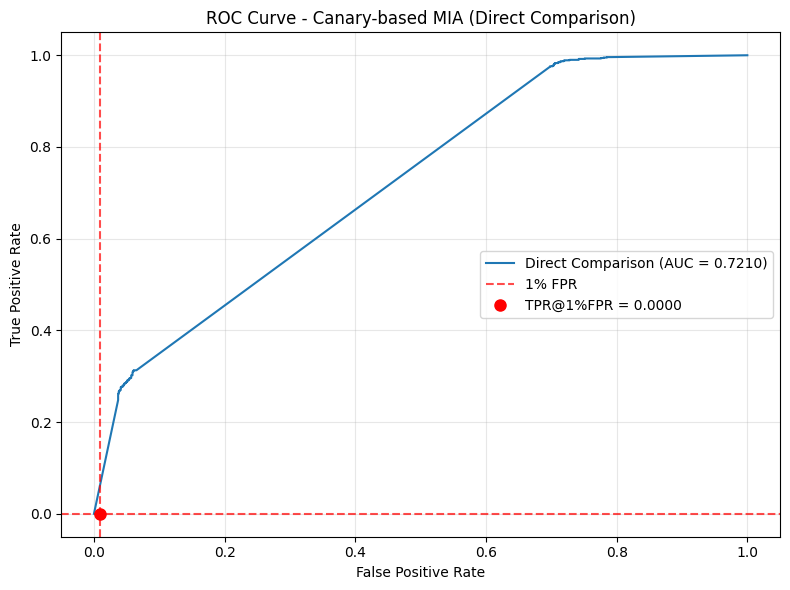

In [ ]:
#!/usr/bin/env python
"""
Canary-based MIA using direct score comparison (no attack classifier)
For each test sample, compare target model loss vs shadow model reference distributions
"""

import json
import numpy as np
import torch
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


def compute_loss_for_samples(model, tokenizer, texts, max_len=512, batch_size=4):
    """Compute per-sample loss"""
    model.eval()
    device = next(model.parameters()).device
    losses = []

    print(f"Computing losses for {len(texts)} samples...")

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
            batch_texts = texts[i:i+batch_size]

            # Tokenize
            encodings = tokenizer(
                batch_texts,
                max_length=max_len,
                truncation=True,
                padding="max_length",
                return_tensors="pt"
            )

            input_ids = encodings["input_ids"].to(device)
            attention_mask = encodings["attention_mask"].to(device)

            # Compute loss
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)

            # Per-sample loss (mean over sequence length)
            shift_logits = outputs.logits[:, :-1, :].contiguous()
            shift_labels = input_ids[:, 1:].contiguous()
            shift_mask = attention_mask[:, 1:].contiguous()

            loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            loss = loss.view(shift_labels.size())

            # Mask and average
            loss = (loss * shift_mask).sum(dim=1) / shift_mask.sum(dim=1)
            losses.extend(loss.cpu().numpy().tolist())

    return np.array(losses)


def load_model(model_path):
    """Load a fine-tuned model"""
    print(f"Loading model from {model_path}...")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path)

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    if torch.cuda.is_available():
        model = model.cuda()
        print(f"✓ Model loaded on GPU")
    else:
        print(f"✓ Model loaded on CPU")

    return model, tokenizer


def main():
    print("=" * 80)
    print("CANARY-BASED MIA: DIRECT SCORE COMPARISON")
    print("=" * 80)

    # Configuration - UPDATE THESE PATHS
    TARGET_MODEL_PATH = "./models/train/gpt2_3_lora32_adamw_b8_lr2"
    SHADOW_MODEL_DIR = "./models/shadow_model_canary/models"  # Adjust if different
    TARGET_TEST_PATH = "./data/train/test.json"
    CANARY_DATA_DIR = "./data/shadow_data_canary"  # Where canary_data_gen.py saved data
    MAX_LEN = 512

    # Load target test data
    print(f"\nLoading target test set from {TARGET_TEST_PATH}...")
    if not Path(TARGET_TEST_PATH).exists():
        raise FileNotFoundError(f"Target test file not found: {TARGET_TEST_PATH}")

    target_test = json.load(open(TARGET_TEST_PATH))
    print(f"✓ Loaded {len(target_test)} test samples")

    # Load target model
    if not Path(TARGET_MODEL_PATH).exists():
        raise FileNotFoundError(f"Target model not found: {TARGET_MODEL_PATH}")

    target_model, target_tokenizer = load_model(TARGET_MODEL_PATH)

    # Compute target losses on ALL test samples
    print("\n" + "=" * 80)
    print("STEP 1: Computing Target Model Losses")
    print("=" * 80)
    target_losses = compute_loss_for_samples(target_model, target_tokenizer, target_test, max_len=MAX_LEN)
    print(f"✓ Target losses computed")
    print(f"  Mean: {target_losses.mean():.4f}")
    print(f"  Std:  {target_losses.std():.4f}")
    print(f"  Min:  {target_losses.min():.4f}")
    print(f"  Max:  {target_losses.max():.4f}")

    # Free target model memory
    del target_model
    torch.cuda.empty_cache()

    # Load shadow models and compute reference distributions
    print("\n" + "=" * 80)
    print("STEP 2: Building Reference Distributions from Shadow Models")
    print("=" * 80)

    # For each canary, collect losses from shadows that saw it (member) vs didn't see it (non-member)
    member_losses_per_canary = {}  # canary_idx -> list of losses from shadows that saw it
    non_member_losses_per_canary = {}  # canary_idx -> list of losses from shadows that didn't see it

    for shadow_id in range(5):
        shadow_path = Path(SHADOW_MODEL_DIR) / f"shadow_{shadow_id}" / "gpt2_shadow"
        canary_mapping_path = Path(CANARY_DATA_DIR) / f"shadow_{shadow_id}" / "canary_mapping.json"

        if not shadow_path.exists():
            print(f"⚠ Shadow model {shadow_id} not found at {shadow_path}, skipping...")
            continue

        if not canary_mapping_path.exists():
            print(f"⚠ Canary mapping {shadow_id} not found at {canary_mapping_path}, skipping...")
            continue

        print(f"\nProcessing Shadow Model {shadow_id}...")
        shadow_model, shadow_tokenizer = load_model(str(shadow_path))

        # Load canary mapping
        canary_mapping = json.load(open(canary_mapping_path))
        my_canary_indices = set(canary_mapping["canary_indices"])
        print(f"  This shadow saw canaries: {min(my_canary_indices)} to {max(my_canary_indices)}")

        # Compute losses on ALL target test samples
        shadow_losses = compute_loss_for_samples(shadow_model, shadow_tokenizer, target_test, max_len=MAX_LEN)
        print(f"  Shadow losses computed: mean={shadow_losses.mean():.4f}")

        # Categorize losses
        for idx, loss in enumerate(shadow_losses):
            if idx in my_canary_indices:
                # This shadow saw this canary (member)
                if idx not in member_losses_per_canary:
                    member_losses_per_canary[idx] = []
                member_losses_per_canary[idx].append(loss)
            else:
                # This shadow didn't see this canary (non-member)
                if idx not in non_member_losses_per_canary:
                    non_member_losses_per_canary[idx] = []
                non_member_losses_per_canary[idx].append(loss)

        del shadow_model  # Free memory
        torch.cuda.empty_cache()

    # STEP 3: Make predictions using distribution comparison
    print("\n" + "=" * 80)
    print("STEP 3: Predicting Membership via Distribution Comparison")
    print("=" * 80)

    predictions = []
    scores = []  # Membership scores (higher = more likely member)
    method_stats = {"distance": 0, "threshold": 0, "neutral": 0}

    for idx in range(len(target_test)):
      target_loss = target_losses[idx]

      # Get reference distributions
      member_losses = member_losses_per_canary.get(idx, [])
      non_member_losses = non_member_losses_per_canary.get(idx, [])

      if not member_losses or not non_member_losses:
          score = 0.5
          method_stats["neutral"] += 1
      else:
          member_mean = np.mean(member_losses)
          non_member_mean = np.mean(non_member_losses)

          # Score based on how much closer target loss is to member vs non-member mean
          # Use negative loss: lower loss = higher membership probability
          if member_mean < non_member_mean:  # Members should have lower loss
              # Normalize between member and non-member means
              if target_loss <= member_mean:
                  score = 1.0  # Very likely member
              elif target_loss >= non_member_mean:
                  score = 0.0  # Very likely non-member
              else:
                  # Linear interpolation
                  score = 1.0 - (target_loss - member_mean) / (non_member_mean - member_mean)
          else:
              # Fallback if distributions are inverted
              score = 0.5

          # Clip to [0, 1]
          score = np.clip(score, 0.0, 1.0)
          method_stats["distance"] += 1

      scores.append(score)
      predictions.append(1 if score > 0.5 else 0)

    print(f"Prediction methods used:")
    print(f"  Distance comparison: {method_stats['distance']}")
    print(f"  Neutral (missing ref): {method_stats['neutral']}")

    # Save predictions
    print("\n" + "=" * 80)
    print("STEP 4: Saving Results")
    print("=" * 80)

    # Save scores
    with open("predictions_scores_direct.json", "w") as f:
        json.dump(scores, f, indent=2)

    # Save binary predictions
    with open("predictions_direct.json", "w") as f:
        json.dump(predictions, f, indent=2)

    print(f"✓ Predictions saved")
    print(f"  - Predicted members: {sum(predictions)}")
    print(f"  - Predicted non-members: {len(predictions) - sum(predictions)}")
    print(f"  - Mean score: {np.mean(scores):.4f}")

    # Check for validation labels
    label_paths = [
        "./18734-17731_Project_Phase2_3/data/train/test_label.json",
        "./data/train/test_label.json"
    ]

    labels = None
    for label_path in label_paths:
        if Path(label_path).exists():
            labels = json.load(open(label_path))
            print(f"✓ Found validation labels at {label_path}")
            break

    if labels is not None:
        print("\n" + "=" * 80)
        print("VALIDATION METRICS")
        print("=" * 80)

        auc = roc_auc_score(labels, scores)
        print(f"AUC: {auc:.4f}")

        # TPR @ 1% FPR
        fpr, tpr, thresholds = roc_curve(labels, scores)
        idx_1fpr = np.where(fpr <= 0.01)[0]
        if len(idx_1fpr) > 0:
            tpr_at_1fpr = tpr[idx_1fpr[-1]]
            print(f"TPR @ 1% FPR: {tpr_at_1fpr:.4f}")

            if tpr_at_1fpr > 0.15:
                print("✅ SUCCESS: TPR @ 1% FPR > 0.15 (Phase 2 requirement met!)")
            else:
                print("❌ TPR @ 1% FPR < 0.15 (Phase 2 requirement not met)")

        # Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'Direct Comparison (AUC = {auc:.4f})')
        plt.axvline(0.01, color='r', linestyle='--', label='1% FPR', alpha=0.7)
        if len(idx_1fpr) > 0:
            plt.axhline(tpr_at_1fpr, color='r', linestyle='--', alpha=0.7)
            plt.plot(0.01, tpr_at_1fpr, 'ro', markersize=8, label=f'TPR@1%FPR = {tpr_at_1fpr:.4f}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Canary-based MIA (Direct Comparison)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Analyze per-canary performance
        member_indices = [i for i, label in enumerate(labels) if label == 1]
        non_member_indices = [i for i, label in enumerate(labels) if label == 0]

        member_scores = [scores[i] for i in member_indices]
        non_member_scores = [scores[i] for i in non_member_indices]

        print(f"\nScore distributions:")
        print(f"  Members (should be high):     mean={np.mean(member_scores):.4f}, std={np.std(member_scores):.4f}")
        print(f"  Non-members (should be low):  mean={np.mean(non_member_scores):.4f}, std={np.std(non_member_scores):.4f}")

    else:
        print("\n⚠ No validation labels found - running in inference mode")
        print("Results saved for submission to validation/final phases")


if __name__ == "__main__":
    main()